# Dyson Brownian motion

## 1. Static DPP

In [1]:
%pylab inline
from numpy.matlib import repmat
import plotly.graph_objs as go
import plotly.offline
from matplotlib.gridspec import GridSpec
from plot_tools import adjust_spines, sc_law, plot_dpp, plot_traj_with_histo, plot_traj_with_histo_sclaw

Populating the interactive namespace from numpy and matplotlib


In [2]:
def gue(dim, beta, normalization=False):
    """ GUE matrix used to generated the Hermitian Brownian motion as describe in agz
            parameters :
                - beta=1 for GOE et 2 for GUE
                - normalization=True if division by 1/sqrt(N) is wanted (in agz for example)
            """
    B = np.random.randn(dim, dim)
    B_tild = np.random.randn(dim, dim)
    diag = (2/(beta))**0.5 * np.diag(np.diag(B))
    triu = (1/(beta))**0.5 * (np.triu(B,1) + 1j*(beta-1)*np.triu(B_tild,1))
    H = np.zeros((dim,dim)) + diag + triu + triu.T
    if normalization:
        H_return = (1/(dim**0.5))*H
    else:
        H_return = H
    return H_return

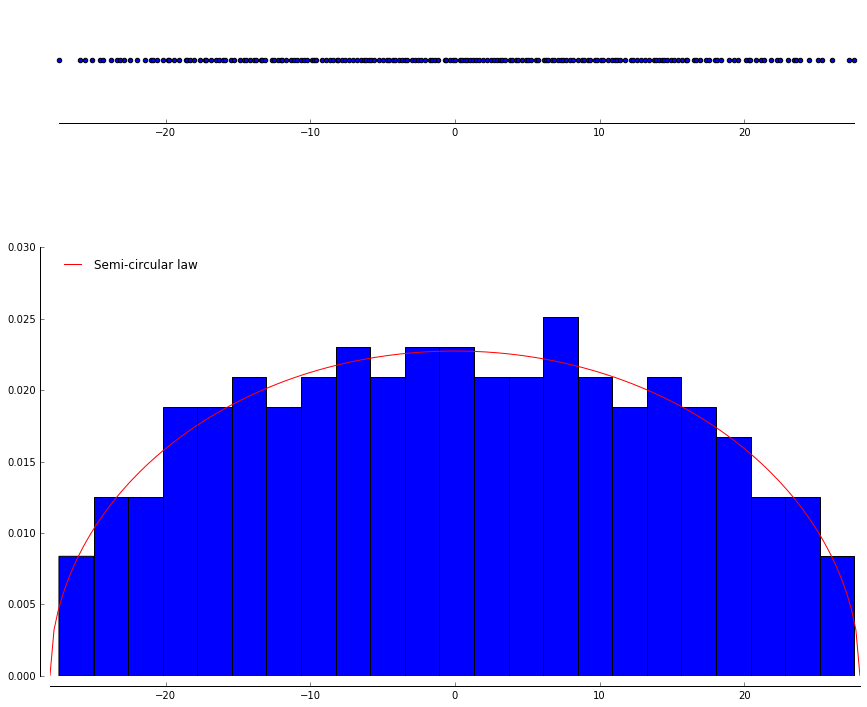

In [3]:
N=200
eigenvalues_samples = np.linalg.eigvalsh(gue(N, 2, normalization=False))

plot_dpp(eigenvalues_samples, 'gue_eigenvalues.png')

## 2. Classic Dyson Brownian motion

In [4]:
class dyson_brownian_motion:
    def __init__(self, n_traj, n_samples, tf, rescaling=False):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.rescaling = rescaling
        self.dt = tf/n_samples
        self.matrices = [np.zeros((self.n_traj, self.n_traj))]
        self.generate()
        self.eigen_values = np.zeros((self.n_samples, self.n_traj))
        self.diag()

    def generate(self):
        if self.rescaling:
            for sample in range(self.n_samples-1):
                self.matrices.append(self.matrices[sample] + gue(self.n_traj, beta=2, normalization=True)*(self.dt)**0.5)
        else:
            for sample in range(self.n_samples-1):
                self.matrices.append(self.matrices[sample] + gue(self.n_traj, beta=2)*(self.dt)**0.5)

    def diag(self):
        if self.rescaling:
            for sample in range(self.n_samples-1):
                eigen_values = \
                    sorted(np.real(np.linalg.eigvals(self.matrices[sample+1])), reverse=True)
                self.eigen_values[sample+1] = np.multiply(eigen_values, 1/np.sqrt((sample+1)*self.dt))
                #print(1/np.sqrt((sample+1)*self.dt))
        else:
            for sample in range(self.n_samples-1):
                self.eigen_values[sample+1] = \
                    sorted(np.real(np.linalg.eigvals(self.matrices[sample+1])), reverse=True)

In [5]:
dbm = dyson_brownian_motion(150, 100, 1)
#dbm.plotly_plot()

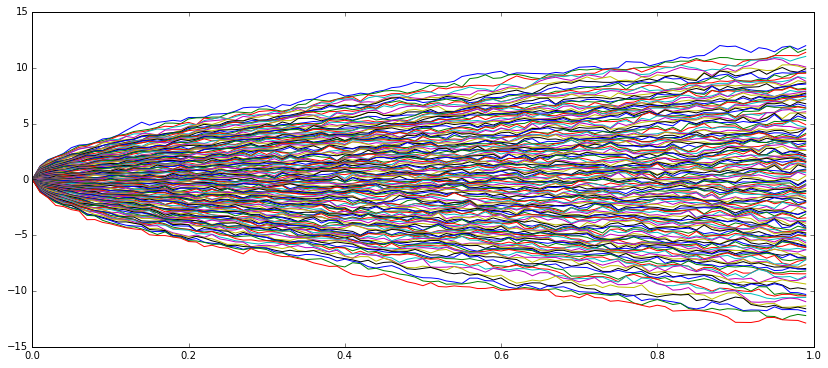

In [6]:
fig = plt.figure(1, figsize=(14, 6))

t = np.matlib.repmat(np.arange(0, dbm.tf, dbm.dt), dbm.n_traj,1)
plt.plot(t.T, dbm.eigen_values)
plt.savefig('dyson_brownian_motion.png', bbox_inches='tight')

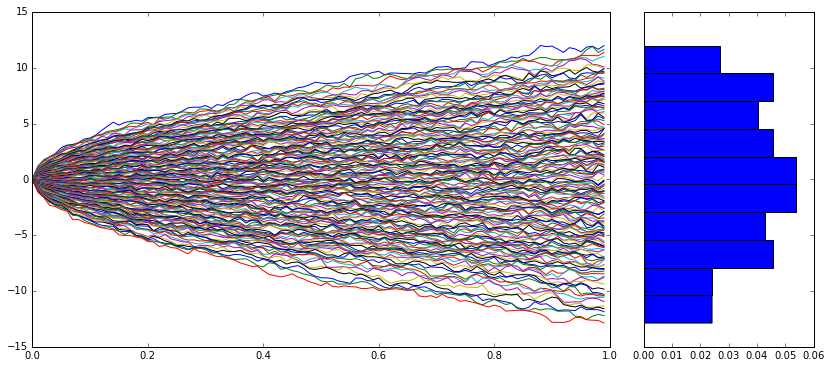

In [7]:
plot_traj_with_histo(dbm, 'dyson_brownian_motion_histo.png')

## 3. Rescaling

In [8]:
dbm_rescale = dyson_brownian_motion(150, 100, 1, rescaling=True)

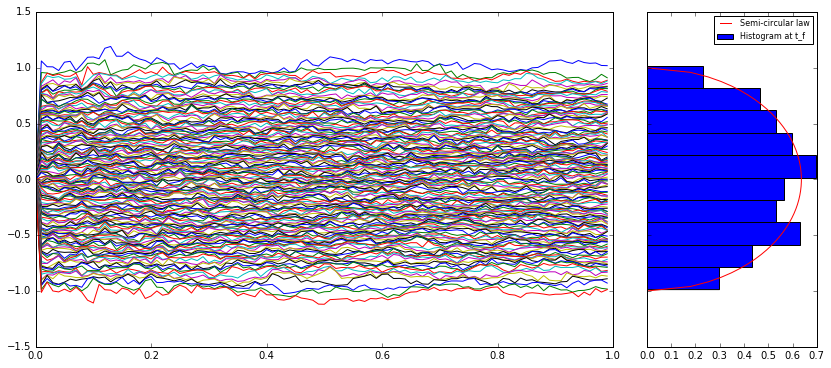

In [9]:
plot_traj_with_histo_sclaw(dbm_rescale, R=1, title='dyson_brownian_motion_rescaled.png')

## 4. Eigenvalues SDE

In [10]:
class dbm_eigen_values:
    def __init__(self, n_traj, n_samples, tf):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf=tf
        self.dt = tf/n_samples
        self.eigen_values = np.zeros((self.n_samples, self.n_traj))
        self.initialisation()
        self.generate()

    def initialisation(self):
        self.eigen_values[0] = np.linspace(1, 0.01, num=self.n_traj)
        #self.eigen_values[0] = np.zeros(self.n_traj)
        return self.eigen_values

    def generate(self):
        for sample in range(self.n_samples-1):
            
            for i in range(self.n_traj):

                lbda_i = self.eigen_values[sample][i]
                eigen_values_list = [lbda for lbda in list(self.eigen_values[sample]) if lbda != lbda_i]

                sum_term = sum ([ (1/(lbda_i - lbda_k)) for lbda_k in eigen_values_list ])
                # print("sumterm", sum_term)

                W = (self.dt)**(0.5) * np.random.randn()
                self.eigen_values[sample+1][i] = self.eigen_values[sample][i] + \
                                                W *(1/self.n_traj)**(0.5) + \
                                                 (1/self.n_traj)*sum_term * self.dt
                # print("eigen:", self.eigen_values[sample+1][i])

            self.eigen_values[sample + 1] = sorted(self.eigen_values[sample + 1])

        return self.eigen_values

In [11]:
test_dbm_eigen_values = dbm_eigen_values(100, 3000, 1)

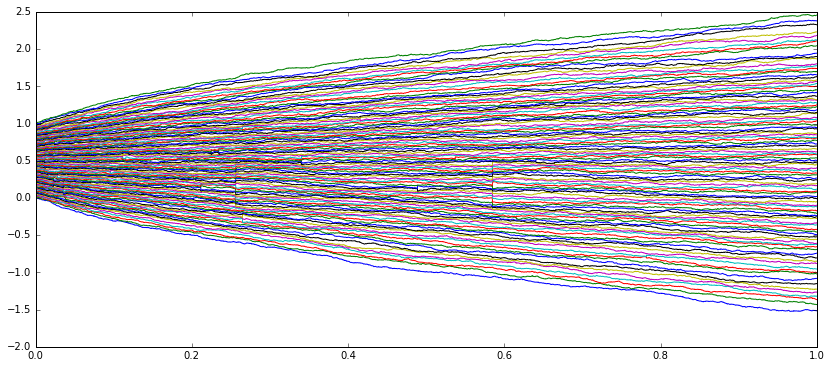

In [12]:
fig = plt.figure(1, figsize=(14, 6))

t = np.matlib.repmat(np.arange(0, test_dbm_eigen_values.tf, test_dbm_eigen_values.dt), test_dbm_eigen_values.n_traj,1)
plt.plot(t.T, test_dbm_eigen_values.eigen_values)
plt.savefig('dbm_eigenvalues.png', bbox_inches='tight')